In [9]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import Sequence

In [2]:
# === RUTAS ===
cracked_dir = r'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\ModeloIA\datasets\cracks'
holes_dir = r'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\ModeloIA\datasets\holes\images'
postesCaidos_dir =r'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\ModeloIA\datasets\PostesCaidos\train' 
sinIncidencia_dir = r'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\ModeloIA\datasets\sinIncidencia'


In [10]:

# Crear listas con rutas y etiquetas
image_paths = []
labels = []

for f in os.listdir(cracked_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_paths.append(os.path.join(cracked_dir, f))
        labels.append(0)  # Grieta

for f in os.listdir(holes_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_paths.append(os.path.join(holes_dir, f))
        labels.append(1)  # Agujero

for f in os.listdir(postesCaidos_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_paths.append(os.path.join(postesCaidos_dir, f))
        labels.append(2)  # Postes Caídos

for f in os.listdir(sinIncidencia_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_paths.append(os.path.join(sinIncidencia_dir, f))
        labels.append(3)  # Sin incidencia

print(f"Total imágenes encontradas: {len(image_paths)}")

Total imágenes encontradas: 36424


In [11]:
# Crear DataFrame con rutas y etiquetas
df = pd.DataFrame({'filename': image_paths, 'label': labels})

# División en entrenamiento y validación
df_train, df_val = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


In [12]:
# Función para cargar y preprocesar imagen (igual que antes)
def cargar_y_preprocesar_cv2(file_path):
    img = cv2.imread(file_path)
    if img is None:
        raise ValueError(f"No se pudo cargar la imagen: {file_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    img_resized = cv2.resize(img_eq, (224, 224))
    img_resized = img_resized.astype(np.float32)

    # Normalización para MobileNetV2
    img_preproc = preprocess_input(img_resized)
    return img_preproc

In [ ]:
# Generador personalizado para cargar datos
class DataGenerator(Sequence):
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.loc[batch_indexes]

        images = []
        labels = []

        for _, row in batch_df.iterrows():
            img = cargar_y_preprocesar_cv2(row['filename'])
            images.append(img)
            labels.append(row['label'])

        return np.array(images), np.array(labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [14]:
# Crear generadores para entrenamiento y validación
train_generator = DataGenerator(df_train, batch_size=32)
val_generator = DataGenerator(df_val, batch_size=32, shuffle=False)

# Calcular pesos de clase para balancear el entrenamiento
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['label']),
    y=df_train['label']
)
class_weights = dict(enumerate(class_weights_array))

# Modelo MobileNetV2 con clasificación personalizada
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
x = base_model.output
output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Fine-tuning: entrenar últimas 50 capas
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compilación del modelo
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callback para early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Entrenamiento
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=2
)

C:\Users\marco\AppData\Local\Temp\ipykernel_65120\1757599685.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
c:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


c:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


911/911 - 1673s - 2s/step - accuracy: 0.7663 - loss: 0.3983 - val_accuracy: 0.7688 - val_loss: 0.7172
Epoch 2/30
911/911 - 1538s - 2s/step - accuracy: 0.9619 - loss: 0.0905 - val_accuracy: 0.9450 - val_loss: 0.2016
Epoch 3/30
911/911 - 1018s - 1s/step - accuracy: 0.9784 - loss: 0.0491 - val_accuracy: 0.9702 - val_loss: 0.1056
Epoch 4/30
911/911 - 777s - 852ms/step - accuracy: 0.9859 - loss: 0.0303 - val_accuracy: 0.9827 - val_loss: 0.0633
Epoch 5/30
911/911 - 795s - 873ms/step - accuracy: 0.9897 - loss: 0.0212 - val_accuracy: 0.9901 - val_loss: 0.0405
Epoch 6/30
911/911 - 789s - 866ms/step - accuracy: 0.9925 - loss: 0.0160 - val_accuracy: 0.9927 - val_loss: 0.0280
Epoch 7/30
911/911 - 799s - 877ms/step - accuracy: 0.9944 - loss: 0.0130 - val_accuracy: 0.9945 - val_loss: 0.0182
Epoch 8/30
911/911 - 794s - 871ms/step - accuracy: 0.9947 - loss: 0.0110 - val_accuracy: 0.9940 - val_loss: 0.0236
Epoch 9/30
911/911 - 803s - 882ms/step - accuracy: 0.9964 - loss: 0.0074 - val_accuracy: 0.9938 -

In [17]:
from sklearn.metrics import classification_report
import numpy as np

# Obtener predicciones del modelo
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas verdaderas directamente del dataframe
y_true = df_val['label'].values  # O val_generator.df['label'].values

# Reporte de clasificación
print(classification_report(y_true, y_pred_labels, digits=4))


228/228 ━━━━━━━━━━━━━━━━━━━━ 172s 755ms/step
              precision    recall  f1-score   support

           0     0.9987    0.9987    0.9987      1493
           1     0.9267    0.9720    0.9488       143
           2     0.9396    0.9655    0.9524       145
           3     0.9987    0.9967    0.9977      5504

    accuracy                         0.9960      7285
   macro avg     0.9659    0.9832    0.9744      7285
weighted avg     0.9961    0.9960    0.9961      7285



In [23]:
%pip install scikit-image

  Using cached scikit_image-0.25.2-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached scikit_image-0.25.2-cp310-cp310-win_amd64.whl (12.8 MB)
Using cached imageio-2.37.0-py3-none-any.whl (315 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)

   ------------- -------------------------- 1/3 [imageio]
   ------------- -------------------------- 1/3 [imageio]
   -------------------------- ------------- 2/3 [scikit-image]
   -------------------------- ------------- 2/3 [scikit-image]
   -------------------------- ------------- 2/3 [scikit-image]
   -------------------------- ------------- 2/3 [scikit-image]
   -------------------------- ------------- 2/3 [scikit-image]
   -------------------------- ------------- 2/3 [scikit-image]
   -------------------------- ------------- 2/3 [scikit-image]
   -------------------------- ------------- 2/3 [scikit-

In [24]:

import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def predecir_imagen(file_path):
    img = imread(file_path)
    img_resized = resize(img, output_shape=(224, 224), preserve_range=True)
    img_preprocessed = preprocess_input(img_resized.astype(np.float32))
    img_batch = np.expand_dims(img_preprocessed, axis=0)

    pred = model.predict(img_batch)
    clase = np.argmax(pred)
    confianza = pred[0][clase] * 100

    etiquetas = ['Grieta', 'Agujero', 'Poste caído', 'Sin incidencia']
    print(f"Predicción: {etiquetas[clase]} ({confianza:.2f}%)")

    plt.imshow(img)
    plt.title(f"{etiquetas[clase]} ({confianza:.1f}%)")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicción: Grieta (81.59%)


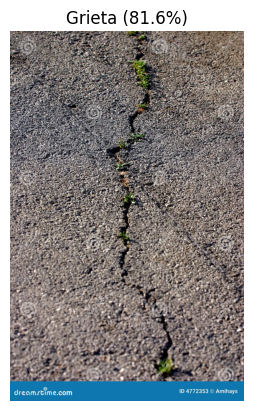

In [30]:
predecir_imagen(r'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\ModeloIA\IMG\grieta.webp')

In [34]:
import tensorflow as tf
import os

# Ruta donde guardar el modelo (debe estar vacía o no contener archivos conflictivos)
save_path = r'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\app\app\src\main\assets\modelo_entrenado'

# Asegurarse de que la carpeta existe
os.makedirs(save_path, exist_ok=True)

# Exportar como SavedModel (necesario para TFLite)
model.export(save_path)

# Convertir a TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()

# Guardar .tflite en la carpeta assets
tflite_output_path = os.path.join(os.path.dirname(save_path), 'modelo_entrenado.tflite')
with open(tflite_output_path, 'wb') as f:
    f.write(tflite_model)

print("✅ Modelo exportado y convertido a TFLite en:", tflite_output_path)


INFO:tensorflow:Assets written to: C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\app\app\src\main\assets\modelo_entrenado\assets


INFO:tensorflow:Assets written to: C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\app\app\src\main\assets\modelo_entrenado\assets


Saved artifact at 'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\app\app\src\main\assets\modelo_entrenado'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2165824427408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165819871424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165819872480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165819867552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165819869664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165819878464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165819876880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165819880048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165819875648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  216581